Let's try to take a look at the Airbnb listings and see if we can accurately predict the prices based on the 

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb



%config InlineBackend.figure_format = 'png'


In [16]:
train = pd.read_csv("../input/listings.csv")

Let's just keep some columns since there are so many of them:

In [17]:
columns_to_keep = ["price", "neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "name", "summary",
                   "amenities", "latitude", "longitude", "number_of_reviews",
                   "require_guest_phone_verification", "minimum_nights"]

train = train[columns_to_keep]

In [18]:
train.head(3)

,price,neighbourhood_cleansed,bedrooms,property_type,room_type,name,summary,amenities,latitude,longitude,number_of_reviews,require_guest_phone_verification,minimum_nights
0,$250.00,Roslindale,2.0,House,Entire home/apt,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ...",42.282619,-71.133068,0,f,2
1,$65.00,Roslindale,1.0,Apartment,Private room,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",42.286241,-71.134374,36,f,2
2,$65.00,Roslindale,1.0,Apartment,Private room,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",42.292438,-71.135765,41,f,3


Let's clean up the data a bit. We will define a function called clean that tidies up some of the columns:

In [19]:
def clean(train):

    train["bedrooms"] = train["bedrooms"].fillna(0.5) #these are studios
    train["summary"] = train["summary"].fillna("")
    train["bedrooms"] = train["bedrooms"].astype("str")

    #replace unpopular types with other 
    popular_types = train["property_type"].value_counts().head(6).index.values
    train.loc[~train.property_type.isin(popular_types), "property_type"] = "Other"

    #make price numeric:
    train["price"] = train["price"].str.replace("[$,]", "").astype("float")
    #eliminate crazy prices:
    train = train[train["price"] < 600]
    
    return train

In [20]:
train = clean(train)

### EDA:

Let's look at the distribution of prices:

98.37957922657978

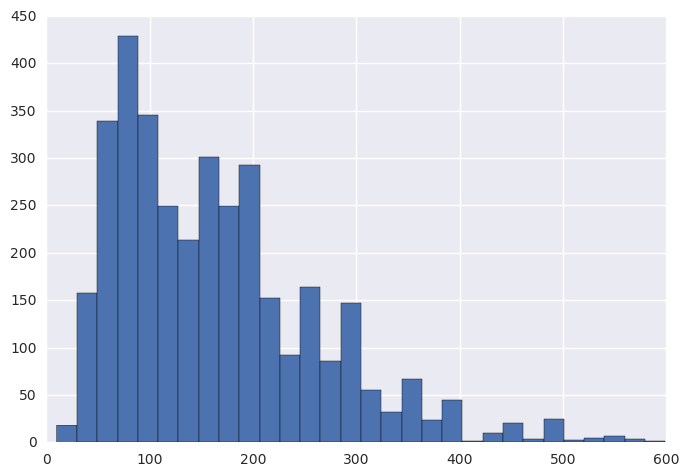

In [21]:
train["price"].hist(bins = 30)
train["price"].std()

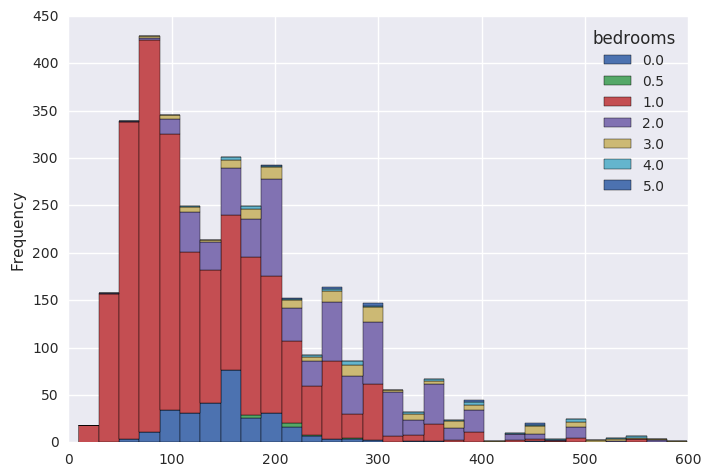

In [22]:
(train.pivot(columns = "bedrooms", values = "price")
         .plot.hist(bins = 30, stacked = True))

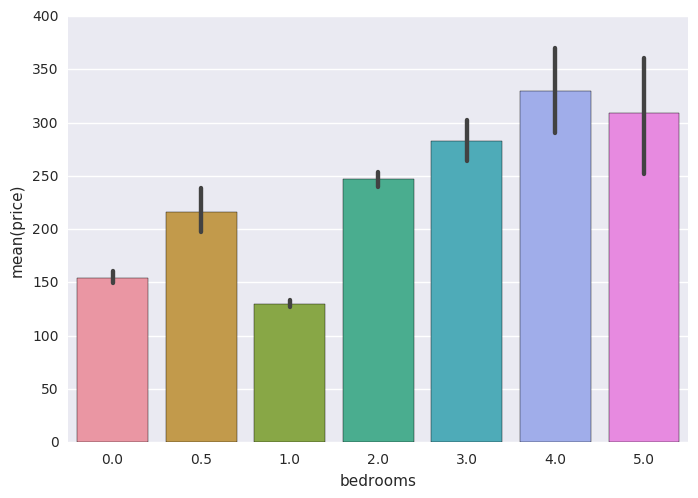

In [23]:
sns.barplot(x = "bedrooms", y = "price", data = train)

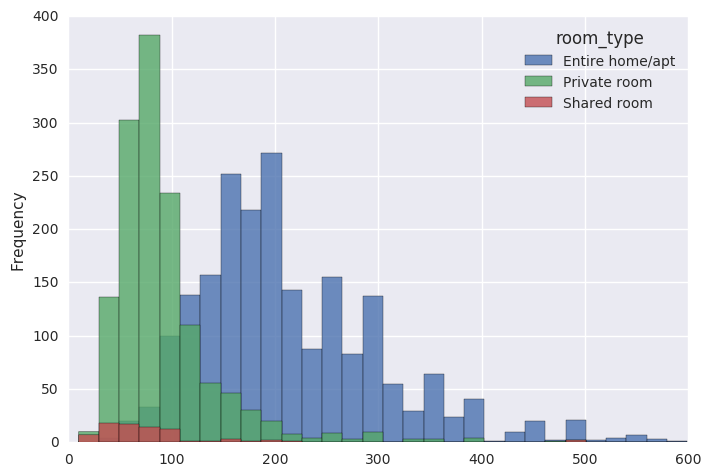

In [11]:
(train.pivot(columns = "room_type", values = "price")
         .plot.hist(bins = 30, stacked = False, alpha = 0.8))

###  Pre-Processing:

This is a pretty interesting dataset since it contains very "diverse" data classes: looks like we have numerical, categorical and text data.  Let's split them up in two group since text data needs to be processed differently:

In [24]:
y = train["price"]
train_num_cat = train[["neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "latitude", "longitude",
                   "number_of_reviews", "require_guest_phone_verification",
                    "minimum_nights"]]

train_text = train[["name", "summary", "amenities"]]

Now let's one hot encode the categorical data:

In [25]:
X_num = pd.get_dummies(train_num_cat)

In [26]:
train_text.head()

,name,summary,amenities
0,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ..."
1,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
2,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit..."
3,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
4,Come Home to Boston,"My comfy, clean and relaxing home is one block...","{Internet,""Wireless Internet"",""Air Conditionin..."


Amenities are interesting. I will follow the same idea as in a previous script [here](https://www.kaggle.com/residentmario/d/airbnb/boston/modeling-prices) and one-hot encode the amenities. Since the are formatted rather oddly this will take a few lines of code:

In [27]:
train.amenities = train.amenities.str.replace("[{}]", "")
amenities =  ",".join(train.amenities)
amenities = np.unique(amenities.split(","))
amenities_dict = dict(enumerate(amenities))

train.amenities = train.amenities.str.split(",")
amenity_ohe = [[ame in amenity_list for ame in amenities]
                                    for amenity_list in train.amenities]
amenity_ohe = np.array(amenity_ohe)

In [29]:
amenity_ohe

array([[False, False, False, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]], dtype=bool)

What shall we do with the name and summary data? Let's just concatenate the two and then create a bag of words from them.

In [42]:
train["text"] = train["name"].str.cat(train["summary"], sep = " ")

In [45]:
vect = CountVectorizer(stop_words = "english", min_df = 10)
X_text = vect.fit_transform(train["text"])


### Models:

In [55]:
#metric:
def rmse(y_true, y_pred):
    return(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))


In [ ]:
Ok so we have three different matrices: 

In [47]:
(X_num.shape, X_text.shape, amenity_ohe.shape)

((3536, 48), (3536, 1100), (3536, 46))

To test our different models we will do repeated train-validation split (note this is not exactly cross validation) and then see how our errors are distributed.

In [61]:
results = []
for i in range(30):
    X_tr, X_val, y_tr, y_val = train_test_split(X_num, y)
    y_baseline = [np.mean(y_tr)]*len(y_val)

    model = Ridge(alpha = 5)
    preds_logit = model.fit(X_tr, y_tr).predict(X_val)


    model = xgb.XGBRegressor()  
    preds_xgb = model.fit(X_tr, y_tr).predict(X_val)
    
    results.append((rmse(y_baseline, y_val),
                    rmse(preds_logit, y_val),
                    rmse(preds_xgb, y_val)
                    ))

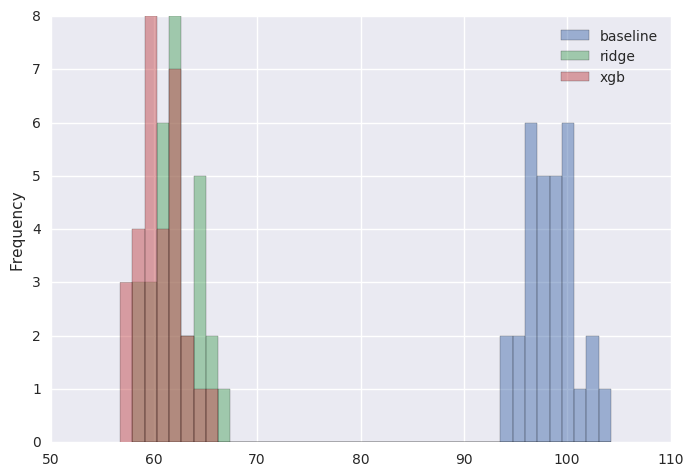

In [62]:
results = pd.DataFrame(results, columns = ["baseline", "ridge", "xgb"])
results.plot.hist(bins = 15, alpha = 0.5)

In [82]:
pd.DataFrame([results.mean(), results.std()])

,baseline,ridge,xgb
0,98.391263,62.154227,60.620437
1,2.454866,2.204669,2.145738
